##Инфа о GPU##

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 21 17:24:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Импорт##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Hand Segmentation/train.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/sample_data/')

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Hand Segmentation/test.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/sample_data/')

##Подключение библиотек##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

##Подключение csv с колаба##



In [ ]:
df = pd.read_csv('/sample_data/train/segmentation.csv')
df.shapedf = pd.read_csv('/sample_data/train/segmentation.csv')
df.shape
df.image = df.image.apply(lambda x: '/sample_data' + '/'+'/'.join(x.split('/')[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


##Подключение csv с гуглдиска##

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/HandSegmentation/train/segmentation.csv')
df.shapedf = pd.read_csv('/content/drive/MyDrive/HandSegmentation/train/segmentation.csv')
df.shape
df.image = df.image.apply(lambda x: '/content/drive/MyDrive/HandSegmentation' + '/'+'/'.join(x.split('/')[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


##Проверка данных##

Функция декодировки RLE

In [ ]:
def rle_decode(mask_rle, shape=(640, 480, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

Делим данные

In [ ]:
train_df = df[:18738]
val_df = df[18738:]

Смотрим на них

In [ ]:
train_df.head()

,image,segmentation
0,/sample_data/train/q/images/000704.png,71281 9 71759 13 72237 17 72716 19 73195 21 73...
1,/sample_data/train/x/images/000169.png,117278 7 117756 13 118233 17 118712 20 119191 ...
2,/sample_data/train/u/images/000314.png,111443 9 111922 14 112400 18 112879 22 113359 ...
3,/sample_data/train/z/images/000560.png,109084 1 109560 8 110039 11 110518 14 110997 1...
4,/sample_data/train/n/images/000382.png,133157 7 133230 13 133633 15 133706 21 133742 ...


In [ ]:
img_name, mask_rle = train_df.iloc[0]
print(img_name)
img = cv2.imread(img_name)
mask = rle_decode(mask_rle, shape=img.shape[1::-1]).T

/sample_data/train/q/images/000704.png


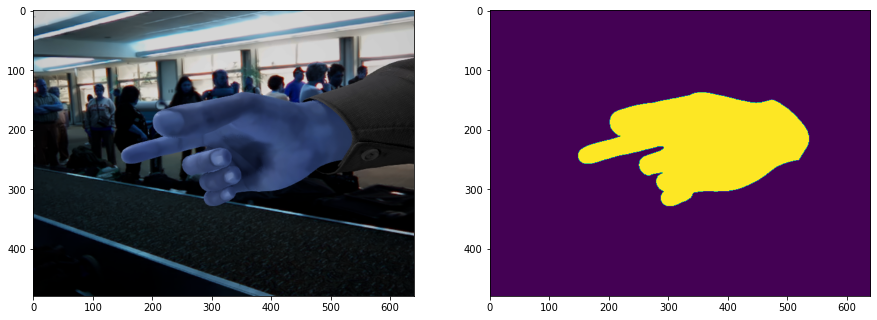

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(img)
axes[1].imshow(mask)

plt.show()

In [ ]:
train_df.head()

,image,segmentation
0,/sample_data/train/q/images/000704.png,71281 9 71759 13 72237 17 72716 19 73195 21 73...
1,/sample_data/train/x/images/000169.png,117278 7 117756 13 118233 17 118712 20 119191 ...
2,/sample_data/train/u/images/000314.png,111443 9 111922 14 112400 18 112879 22 113359 ...
3,/sample_data/train/z/images/000560.png,109084 1 109560 8 110039 11 110518 14 110997 1...
4,/sample_data/train/n/images/000382.png,133157 7 133230 13 133633 15 133706 21 133742 ...


##Создание batchей##

Функция создания пакетов для керас

In [ ]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread(img_name)
            mask = rle_decode(mask_rle, shape=img.shape[1::-1]).T
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

Прогоняем тренировочные данные через функцию

In [ ]:
for x, y in keras_generator(train_df, 16):
    break

In [ ]:
x.shape

(16, 256, 256, 3)

In [ ]:
y.shape

(16, 256, 256, 1)

# FCN

In [ ]:
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

ImportError: ignored

##Создание новой сетки##

In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)

base_out = base_model.output

up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(inputs=base_model.input, outputs=conv)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
pred = model.predict(x)

In [ ]:
pred.shape

(16, 256, 256, 1)

Настройка callbacks

In [ ]:
metric='val_loss'
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor=metric,
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto')

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor=metric,
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto')


callbacks = [best_w, last_w]


adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

Конфиги

In [ ]:
import math
BATCH_SIZE = 16
TRAINING_SIZE = 18738
VALIDATION_SIZE = 2082
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 16))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

Обучение

In [ ]:
model.fit(keras_generator(train_df, BATCH_SIZE),
              steps_per_epoch=steps_per_epoch, #X_train.shape[0] // 50
              epochs=10, #можно попробовать 100 эпох и меньше шагов
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, BATCH_SIZE),
              validation_steps=val_steps, #X_val.shape[0] // 50)
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/10
1172/1172 [==============================] - 323s 273ms/step - loss: 0.1963 - val_loss: 0.0380
Epoch 2/10
1172/1172 [==============================] - 319s 272ms/step - loss: 0.0354 - val_loss: 0.0330
Epoch 3/10
1172/1172 [==============================] - 319s 272ms/step - loss: 0.0310 - val_loss: 0.0313
Epoch 4/10
1172/1172 [==============================] - 319s 272ms/step - loss: 0.0296 - val_loss: 0.0304
Epoch 5/10
1172/1172 [==============================] - 319s 272ms/step - loss: 0.0293 - val_loss: 0.0289
Epoch 6/10
1172/1172 [==============================] - 319s 272ms/step - loss: 0.0279 - val_loss: 0.0301
Epoch 7/10
1172/1172 [==============================] - 318s 272ms/step - loss: 0.0301 - val_loss: 0.0287
Epoch 8/10
1172/1172 [==============================] - 318s 272ms/step - loss: 0.0296 - val_loss: 0.0317
Epoch 9/10
1172/1172 [==============================] - 318s 272ms/step - loss: 0.0330 - val_loss: 0.0363
Epoch 10/10
1172/1172 [=======================

Сохраняем модель на всякий случай

In [ ]:
model.save('/sample_data/Hands/models/')

INFO:tensorflow:Assets written to: /sample_data/Hands/models/assets


In [ ]:
!zip -r archive.zip /sample_data/Hands/models

  adding: sample_data/Hands/models/ (stored 0%)
  adding: sample_data/Hands/models/saved_model.pb (deflated 91%)
  adding: sample_data/Hands/models/variables/ (stored 0%)
  adding: sample_data/Hands/models/variables/variables.index (deflated 75%)
  adding: sample_data/Hands/models/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: sample_data/Hands/models/keras_metadata.pb (deflated 95%)
  adding: sample_data/Hands/models/assets/ (stored 0%)


In [ ]:
model.save('/content/drive/MyDrive/HandSegmentation/keras_models/model/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HandSegmentation/keras_models/model/assets


##Загрузка существующей сетки##

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/HandSegmentation/keras_models/model')

# Unet with ResNet34 encoder

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

In [ ]:
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block1_out').output
conv3 = base_model.get_layer('conv3_block1_2_relu').output
conv4 = base_model.get_layer('conv4_block2_1_relu').output
conv5 = base_model.get_layer('conv5_block3_1_relu').output


## CODE

inp = base_model.get_layer('input_6').output

In [ ]:
conv1

<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv1_relu')>

In [ ]:
conv2

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'conv2_block1_out')>

In [ ]:
conv3

<KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv3_block1_2_relu')>

In [ ]:
conv4

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'conv4_block2_1_relu')>

In [ ]:
conv5

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'conv5_block3_1_relu')>

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5) #softmax


In [ ]:
conv_conc_5

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'activation_29')>

In [ ]:
model = Model(base_model.input, conv_conc_5)

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto') #, period=1

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto') #, period=1


callbacks = [best_w, last_w]



adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)



model.compile(adam, 'binary_crossentropy')
#opt = tf.keras.optimizers.SGD(learning_rate=1.0e-5,momentum=0.9)
#model.compile(opt,'binary_crossentropy')
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=cat_dice_loss, metrics=['dice']) #'binary_crossentropy'

In [ ]:
import math
BATCH_SIZE = 16
TRAINING_SIZE = 18738
VALIDATION_SIZE = 2082
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 16))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

In [ ]:
!pip install tensorflow=2.2

     |████████████████████████████████| 489.6 MB 22 kB/s 
     |████████████████████████████████| 463 kB 64.4 MB/s 
     |████████████████████████████████| 5.8 MB 68.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
batch_size = 16
model.fit(keras_generator(train_df, batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=val_steps,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5


TypeError: ignored

Сохраним модель

In [ ]:
model.save('/sample_data/Hands/modelUnet5epoch/')

INFO:tensorflow:Assets written to: /sample_data/Hands/modelUnet5epoch/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
!zip -r arch.zip /sample_data/Hands/modelUnet5epoch

  adding: sample_data/Hands/modelUnet5epoch/ (stored 0%)
  adding: sample_data/Hands/modelUnet5epoch/saved_model.pb (deflated 92%)
  adding: sample_data/Hands/modelUnet5epoch/variables/ (stored 0%)
  adding: sample_data/Hands/modelUnet5epoch/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: sample_data/Hands/modelUnet5epoch/variables/variables.index (deflated 81%)
  adding: sample_data/Hands/modelUnet5epoch/assets/ (stored 0%)
  adding: sample_data/Hands/modelUnet5epoch/keras_metadata.pb (deflated 95%)


# Аугментации

In [ ]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)




def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        #RandomCrop(256, 256),
        RandomContrast(),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),
         
        
        
    ],
        p=p)

In [ ]:
augumented_df = pd.read_csv('/sample_data/Hands/train/segmentation.csv')
augumented_df.shapedf = pd.read_csv('/sample_data/Hands/train/segmentation.csv')
augumented_df.shape
augumented_df.image = augumented_df.image.apply(lambda x: '/sample_data/Hands' + '/'+'/'.join(x.split('/')[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [ ]:
augumented_df

,image,segmentation
0,/sample_data/Hands/train/q/images/000704.png,71281 9 71759 13 72237 17 72716 19 73195 21 73...
1,/sample_data/Hands/train/x/images/000169.png,117278 7 117756 13 118233 17 118712 20 119191 ...
2,/sample_data/Hands/train/u/images/000314.png,111443 9 111922 14 112400 18 112879 22 113359 ...
3,/sample_data/Hands/train/z/images/000560.png,109084 1 109560 8 110039 11 110518 14 110997 1...
4,/sample_data/Hands/train/n/images/000382.png,133157 7 133230 13 133633 15 133706 21 133742 ...
...,...,...
20815,/sample_data/Hands/train/z/images/000729.png,99958 8 100436 13 100915 15 101394 17 101873 2...
20816,/sample_data/Hands/train/m/images/000858.png,121663 9 122140 15 122618 19 123096 23 123575 ...
20817,/sample_data/Hands/train/t/images/000312.png,124038 8 124517 11 124995 14 125474 17 125954 ...
20818,/sample_data/Hands/train/v/images/000606.png,77966 10 78444 13 78923 15 79402 17 79882 18 8...


In [ ]:
augumented_train_df = df[:18738]
augumented_val_df = df[18738:]

In [ ]:
img_name, mask_rle = augumented_train_df.iloc[88]
print(img_name)
img = cv2.imread(img_name)
mask = rle_decode(mask_rle, shape=img.shape[1::-1]).T
augmentation = strong_aug(p=1.0)
data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
img, mask = augmented["image"], augmented["mask"]

/sample_data/Hands/train/g/images/000792.png


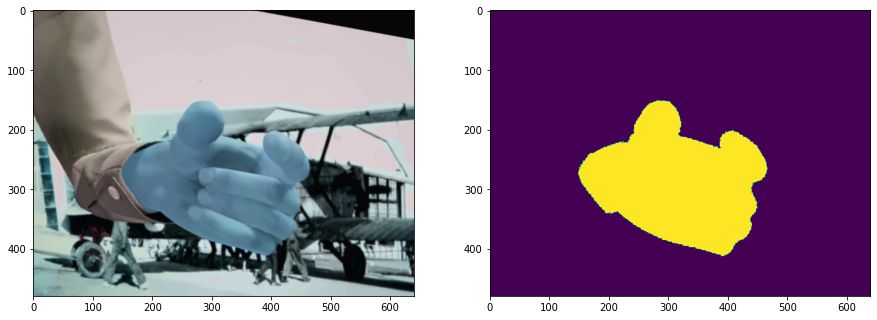

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(img)
axes[1].imshow(mask)

plt.show()

In [ ]:
def augumentation_keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread(img_name)
            mask = rle_decode(mask_rle, shape=img.shape[1::-1]).T
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))

            ###
            augmentation = strong_aug(p=1.0)
            data = {'image': img.astype('uint8'), 'mask': mask}
            augmented = augmentation(**data)
            img, mask = augmented["image"], augmented["mask"]
            ###
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [ ]:
for x, y in augumentation_keras_generator(augumented_train_df, 16):
    break

In [ ]:
x.shape

(16, 256, 256, 3)

In [ ]:
y.shape

(16, 256, 256, 1)

# Vanilla Unet

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation
from keras import backend as K

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_dice_coef', #val_dice_coef
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                save_freq=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_dice_coef', # val_loss
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                save_freq=1)


callbacks = [best_w, last_w]



adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-09, decay=0.0) #epsilon=1e-09


model.compile(adam, 'binary_crossentropy', metrics=[dice_coef])

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/HandSegmentation/vanilla21Depoch.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/sample_data/Hands/modelVanillaUne21D_epoch')


In [ ]:
model = keras.models.load_model('/sample_data/Hands/modelVanillaUne21D_epoch/sample_data/Hands/modelVanillaUne21D_epoch', custom_objects={'dice_coef':dice_coef})

In [ ]:
import math
BATCH_SIZE = 16
TRAINING_SIZE = 18738
VALIDATION_SIZE = 2082
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 16))

steps_per_epoch1 = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

In [ ]:
batch_size = 16
model.fit_generator(augumentation_keras_generator(augumented_train_df, batch_size),
              steps_per_epoch=steps_per_epoch1,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=val_steps,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/3


OSError: ignored

In [ ]:
model.save('/sample_data/Hands/modelVanillaUne24D_epoch/')

INFO:tensorflow:Assets written to: /sample_data/Hands/modelVanillaUne24D_epoch/assets


In [ ]:
!zip -r vanilla24Depoch.zip /sample_data/Hands/modelVanillaUne24D_epoch

  adding: sample_data/Hands/modelVanillaUne24D_epoch/ (stored 0%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/assets/ (stored 0%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/saved_model.pb (deflated 91%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/variables/ (stored 0%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/variables/variables.index (deflated 75%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: sample_data/Hands/modelVanillaUne24D_epoch/keras_metadata.pb (deflated 95%)


#Проверочка#

In [ ]:
pred = model.predict(x)#.shape

In [ ]:
x[1]

array([[[0.15686275, 0.38431373, 0.54901961],
        [0.15686275, 0.38431373, 0.54901961],
        [0.15686275, 0.38431373, 0.54901961],
        ...,
        [0.18823529, 0.38039216, 0.54901961],
        [0.18431373, 0.38039216, 0.54509804],
        [0.18431373, 0.38039216, 0.54509804]],

       [[0.15686275, 0.38431373, 0.54901961],
        [0.15686275, 0.38431373, 0.55294118],
        [0.15686275, 0.38431373, 0.55294118],
        ...,
        [0.18823529, 0.38039216, 0.54901961],
        [0.18431373, 0.38039216, 0.54509804],
        [0.18431373, 0.38039216, 0.54509804]],

       [[0.15686275, 0.38823529, 0.55686275],
        [0.15686275, 0.38823529, 0.55686275],
        [0.15686275, 0.38823529, 0.55686275],
        ...,
        [0.18823529, 0.38039216, 0.54901961],
        [0.18431373, 0.38039216, 0.54509804],
        [0.18431373, 0.38039216, 0.54509804]],

       ...,

       [[0.08235294, 0.44705882, 0.67058824],
        [0.08235294, 0.44313725, 0.66666667],
        [0.0745098 , 0

In [ ]:
x[0] = cv2.imread('tema.jpg')

In [ ]:
pred = model.predict(x)

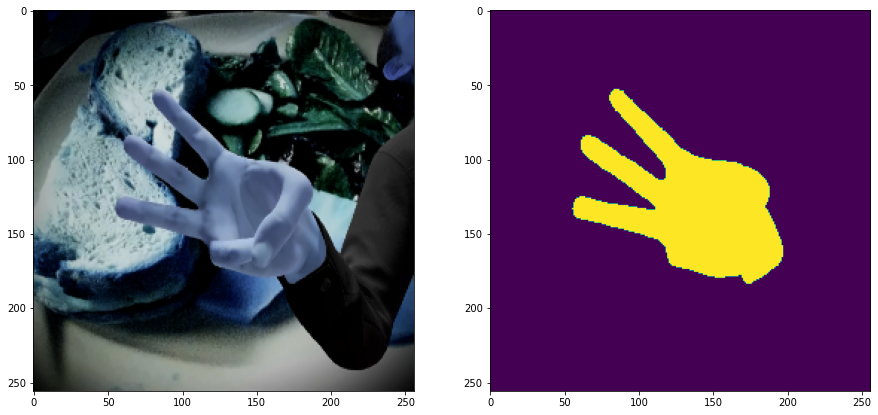

In [ ]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

#Создание датесета для ответа#

#Получение ответа#

Функция кодировки


In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] #.T #sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [ ]:
answers = []
for i in range(0,2):
  image_name = train_df.image[i]
  img = cv2.imread(image_name)
  h,w = img.shape[:2]
  img = cv2.resize(img, (256,256))
  img = img / 255.0
  
  predict = model.predict(img.reshape(1,256,256,3))

  output = predict[0].round()
  output = cv2.resize(output, (w,h))
  answers.append(rle_encoding(output))
  #plt.imsave(f'output{i}.jpg', output, cmap='gray')

AttributeError: ignored

#Запись ответа в csv#

In [ ]:
image_column = test_df.image[:5206]

predictions_column = pd.DataFrame({'segmentation': answers})
#predictions_column = predictions_column.segmentation

data_for_ans_df = [image_column, predictions_column]
answers_df = pd.concat(data_for_ans_df , axis=1)

answers_df.columns = ["image", "segmentation"]

answers_df['segmentation'] = [','.join(map(str, l)) for l in predictions_column['segmentation']]

answers_df['segmentation'] = answers_df['segmentation'].replace({'\[':''}, regex=True)
answers_df['segmentation'] = answers_df['segmentation'].replace({'\]':''}, regex=True)
answers_df['segmentation'] = answers_df['segmentation'].replace({',':' '}, regex=True)

answers_df.head

<bound method NDFrame.head of                                         image                                       segmentation
0        /sample_data/Hands/test/images/0.png  113486 8 113966 8 114446 8 114923 15 115403 15...
1        /sample_data/Hands/test/images/1.png  126904 9 127384 9 127856 25 128336 25 128816 2...
2        /sample_data/Hands/test/images/2.png  127974 14 128454 14 128934 14 129390 4 129407 ...
3        /sample_data/Hands/test/images/3.png  127969 13 128449 13 128929 13 129386 8 129403 ...
4        /sample_data/Hands/test/images/4.png  123099 12 123579 12 124059 12 124536 18 125016...
...                                       ...                                                ...
5201  /sample_data/Hands/test/images/5201.png  79896 13 80376 13 80856 13 81334 17 81814 17 8...
5202  /sample_data/Hands/test/images/5202.png  105236 12 105716 12 106193 18 106673 18 107153...
5203  /sample_data/Hands/test/images/5203.png  129319 5 129799 5 130271 25 130751 25 131231 2...


In [ ]:
answers_df.to_csv('ans.csv', index=False)

#Тестирование ответа#

In [ ]:
ans_df = pd.read_csv('/content/ans.csv')
ans_df.shapedf = pd.read_csv('/content/ans.csv')
ans_df.shape
#ans_df.image = ans_df.image.apply(lambda x: '/sample_data/Hands' + '/'+'/'.join(x.split('/')[1:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


(5206, 2)

In [ ]:
ans_df.head()

,image,segmentation
0,/sample_data/Hands/test/images/0.png,113486 8 113966 8 114446 8 114923 15 115403 15...
1,/sample_data/Hands/test/images/1.png,126904 9 127384 9 127856 25 128336 25 128816 2...
2,/sample_data/Hands/test/images/2.png,127974 14 128454 14 128934 14 129390 4 129407 ...
3,/sample_data/Hands/test/images/3.png,127969 13 128449 13 128929 13 129386 8 129403 ...
4,/sample_data/Hands/test/images/4.png,123099 12 123579 12 124059 12 124536 18 125016...


In [ ]:
def rle_decode(mask_rle, shape=(640, 480, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [ ]:
img_name, mask_rle = ans_df.iloc[2105]
print(img_name)
img = cv2.imread(img_name)
mask = rle_decode(mask_rle, shape=img.shape[1::-1]).T

/sample_data/Hands/test/images/2105.png


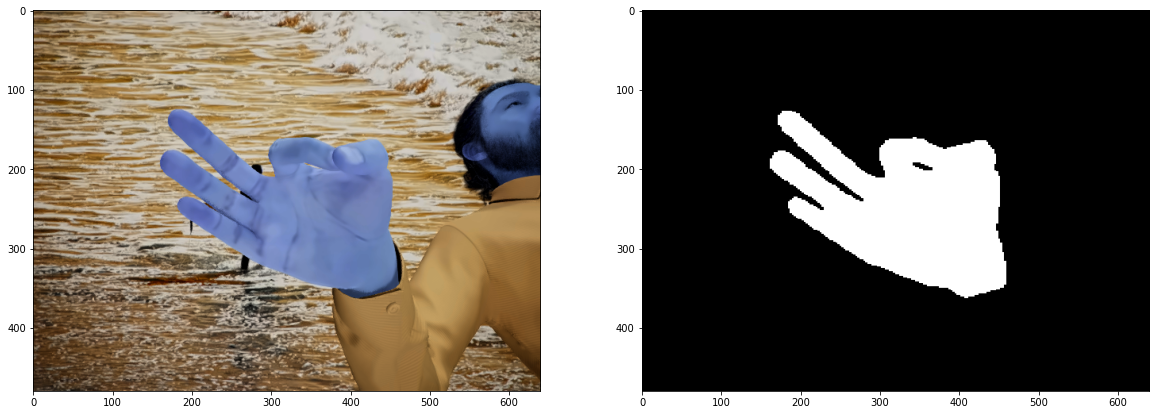

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
axes[0].imshow(img)
axes[1].imshow(mask,cmap='gray')

plt.show()

#Создание ответа для отправки#

In [ ]:
sample_images_column = pd.read_csv('/sample_data/Hands/test/sample_submission.csv')
answers_df.image = sample_images_column.image
answers_df.head

<bound method NDFrame.head of                              image                                       segmentation
0        dataset/test/images/0.png  113486 8 113966 8 114446 8 114923 15 115403 15...
1        dataset/test/images/1.png  126904 9 127384 9 127856 25 128336 25 128816 2...
2        dataset/test/images/2.png  127974 14 128454 14 128934 14 129390 4 129407 ...
3        dataset/test/images/3.png  127969 13 128449 13 128929 13 129386 8 129403 ...
4        dataset/test/images/4.png  123099 12 123579 12 124059 12 124536 18 125016...
...                            ...                                                ...
5201  dataset/test/images/5201.png  79896 13 80376 13 80856 13 81334 17 81814 17 8...
5202  dataset/test/images/5202.png  105236 12 105716 12 106193 18 106673 18 107153...
5203  dataset/test/images/5203.png  129319 5 129799 5 130271 25 130751 25 131231 2...
5204  dataset/test/images/5204.png  82343 9 82823 9 83303 9 83779 17 84259 17 8473...
5205  dataset/test/image

In [ ]:
answers_df.to_csv('ans.csv', index=False)

# Vanilla Unet

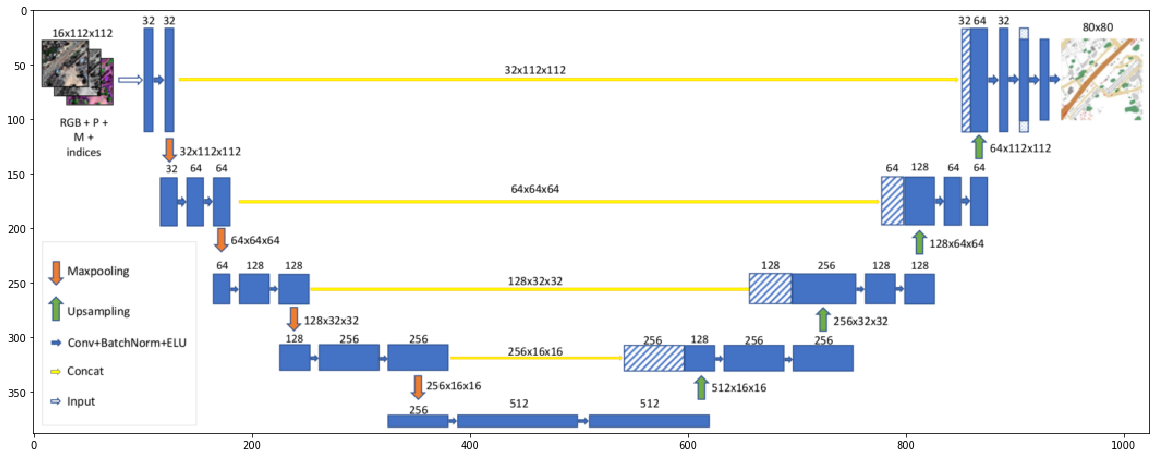

In [ ]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
pool_4, up_1

(<tf.Tensor 'max_pooling2d_39/MaxPool:0' shape=(?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'up_sampling2d_24/ResizeBilinear:0' shape=(?, 32, 32, 256) dtype=float32>)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 34s 339ms/step - loss: 0.3675 - val_loss: 0.1368
Epoch 2/100
100/100 [==============================] - 32s 320ms/step - loss: 0.0909 - val_loss: 0.0704
Epoch 3/100
100/100 [==============================] - 32s 322ms/step - loss: 0.0485 - val_loss: 0.0428
Epoch 4/100
100/100 [==============================] - 32s 322ms/step - loss: 0.0319 - val_loss: 0.0297
Epoch 5/100
100/100 [==============================] - 32s 323ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 6/100
100/100 [==============================] - 33s 326ms/step - loss: 0.0244 - val_loss: 0.0256
Epoch 7/100
  9/100 [=>............................] - ETA: 22s - loss: 0.0241

KeyboardInterrupt: 

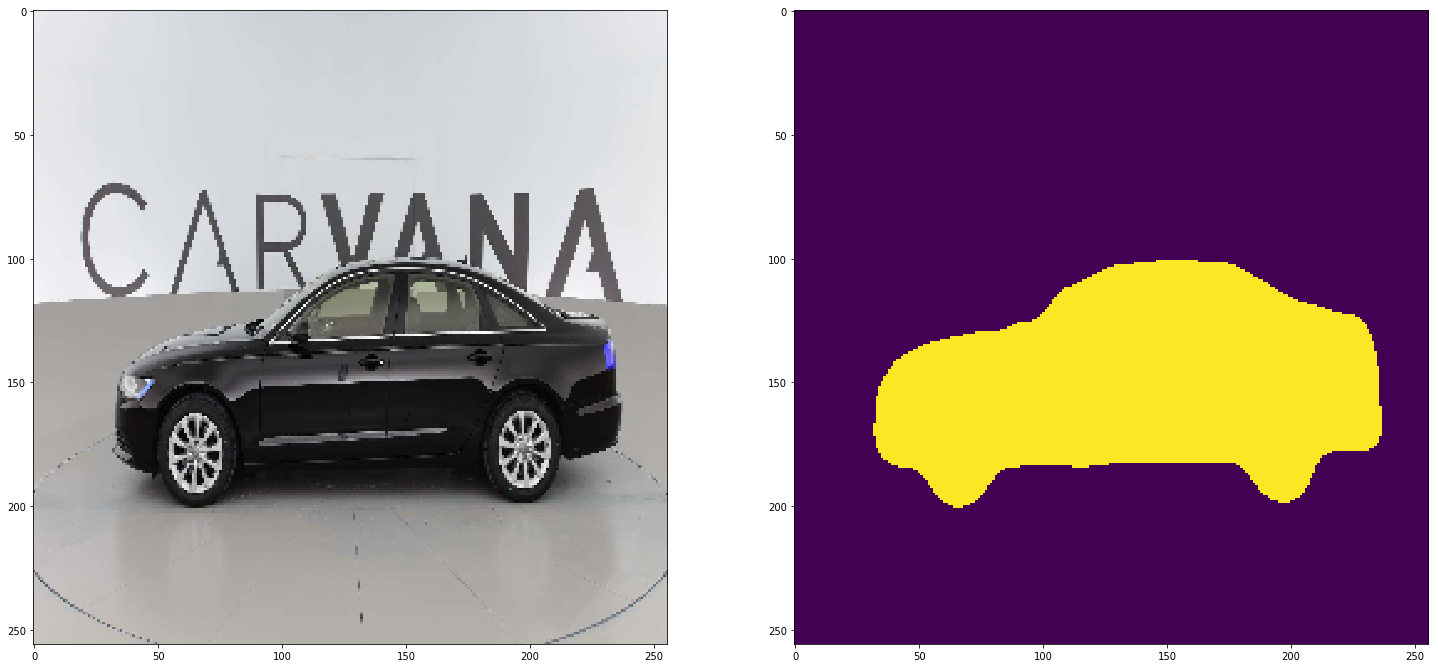

In [ ]:
pred = model.predict(x)#.shape

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# Unet with ResNet34 encoder

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block1_out').output
conv3 = base_model.get_layer('conv3_block1_2_relu').output
conv4 = base_model.get_layer('conv4_block2_1_relu').output
conv5 = base_model.get_layer('conv5_block3_1_relu').output


## CODE

inp = base_model.get_layer('input_1').output

In [ ]:
conv1

<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv1_relu')>

In [ ]:
conv2

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'conv2_block1_out')>

In [ ]:
conv3

<KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'conv3_block1_2_relu')>

In [ ]:
conv4

<KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'conv4_block2_1_relu')>

In [ ]:
conv5

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'conv5_block3_1_relu')>

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('softmax')(conv_conc_5)


NameError: ignored

In [ ]:
conv_conc_5

<tf.Tensor 'activation_190/Sigmoid:0' shape=(?, 256, 256, 1) dtype=float32>

In [ ]:
model = Model(input=base_model.input, output=conv_conc_5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [ ]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
import math
BATCH_SIZE = 16
TRAINING_SIZE = 18738
VALIDATION_SIZE = 2082
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / 16))

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

In [ ]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 44s 436ms/step - loss: 0.0582 - val_loss: 0.0241
Epoch 2/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0182 - val_loss: 0.0163
Epoch 3/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 4/100
100/100 [==============================] - 33s 334ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 5/100
100/100 [==============================] - 33s 333ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 6/100
100/100 [==============================] - 34s 335ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 7/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 8/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 9/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 10/100
  3/100 [..............................] - ETA: 24s

KeyboardInterrupt: 

In [ ]:
img = cv2.imread('prepod.jpg')
mask = cv2.imread('prepod_mak.jpg')

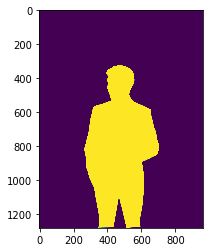

In [ ]:
plt.imshow(mask[..., 0])

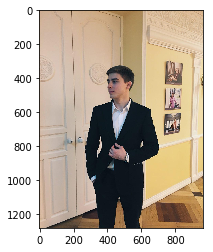

In [ ]:
plt.imshow(img[..., [2,1,0]])

In [ ]:
img.shape

(500, 500, 3)

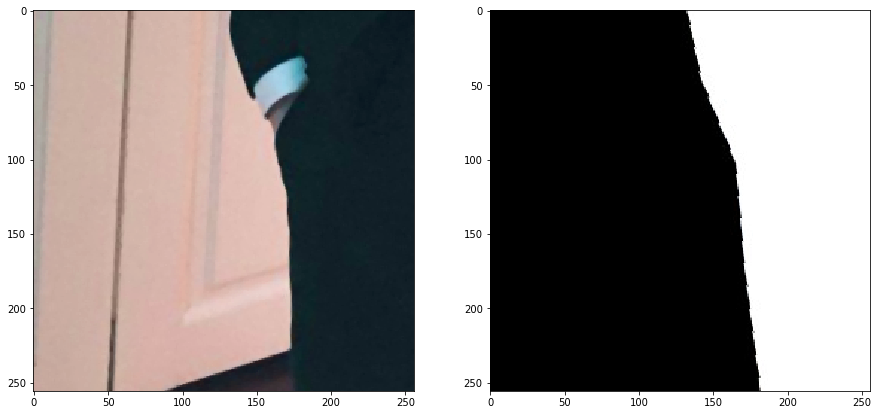

In [ ]:
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()